<a href="https://colab.research.google.com/github/Akadwory/AI_Neurological_Disease_Progression_Prediction/blob/master/AI_BNDP_1_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install MNE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.2 MB/s eta 0:00:00


In [2]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 19.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
import os
import mne
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from nilearn.image import clean_img
from nilearn.image import smooth_img
import numpy as np
import pandas as pd

In [4]:
# Manage GPU memory usage to prevent out of memory (OOM) errors
# This makes TensorFlow allocate memory dynamically as needed
try:
  physical_devices = tf.config.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
  print(f"GPU is available: {physical_devices}")
except:
  print("No GPU Found or TensorFlow Unable To Allocate Memory Dynamically.")

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Access Google Drive in Google Colab**

In [5]:
drive.mount('/content/drive/',force_remount=True)

# OpenNeuro dataset
dataset_path_eeg_rest_state = '/content/drive/MyDrive/AI-BNDP_Prediction/data/eeg_rest_state_Parkinson/'

#PhysioNet EEG dataset
dataset_path_eegmotor = '/content/drive/MyDrive/AI-BNDP_Prediction/data/eeg_motor_movement/'

#fMRI dataset
dataset_path_fmri_parkinson = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/'

Mounted at /content/drive/


In [6]:
print(f"Dataset of UC San Diego Resting State EEG Data from Patients with Parkinson's Disease:{os.listdir(dataset_path_eeg_rest_state)}\n")
print(f"Dataset of EEG Motor Movement/Imagery Dataset: {os.listdir(dataset_path_eegmotor)}\n")
print(f"Dataset of Parkinson's disease functional connectivity, and cognition {os.listdir(dataset_path_fmri_parkinson)}\n")

Dataset of UC San Diego Resting State EEG Data from Patients with Parkinson's Disease:['CHANGES', 'participants.tsv', 'README', 'participants.json', 'dataset_description.json', 'task-rest_beh.json', '.DS_Store', 'sub-hc31', 'sub-pd23', 'sub-pd3', 'sub-pd5', 'sub-hc2', 'sub-hc24', 'sub-pd12', 'sub-hc30', 'sub-hc25', 'sub-hc4', 'sub-pd13', 'sub-hc21', 'sub-hc20', 'sub-hc18', 'sub-hc1', 'sub-pd22', 'sub-hc7', 'sub-hc10', 'sub-pd14', 'sub-hc8', 'sub-pd16', 'sub-pd6', 'sub-pd9', 'sub-hc33', 'sub-hc32', 'sub-pd11', 'sub-pd28', 'sub-pd19', 'sub-hc29', 'sub-pd17', 'sub-pd26']

Dataset of EEG Motor Movement/Imagery Dataset: ['wfdbcal', 'ANNOTATORS', '64_channel_sharbrough.pdf', '64_channel_sharbrough-old.png', '64_channel_sharbrough.png', 'RECORDS', 'SHA256SUMS.txt', '.DS_Store', 'S031', 'S062', 'S007', 'S096', 'S091', 'S009', 'S038', 'S036', 'S065', 'S006', 'S030', 'S039', 'S098', 'S054', 'S037', 'S001', 'S055', 'S053', 'S008', 'S079', 'S052', 'S064', 'S084', 'S046', 'S041', 'S063', 'S090', 'S

**Loading and Visualizing the fMRI Data**
1. Before we dive into functional connectivity analysis or machine learning, we need to ensure the fMRI data is loaded correctly, and we have a clear understanding of its structure and dimensions.

2. Visualizing the fMRI data helps us inspect its quality and spatial resolution before proceeding with preprocessing steps like motion correction and filtering.

**List the fMRI Files**

In [7]:
#List the files in the fMRI dataset folder
dataset_path_fmri_parkinson = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/'
fmri_subjects = os.listdir(dataset_path_fmri_parkinson)
print(f"Subjects in fMRI Dataset: {fmri_subjects}")

Subjects in fMRI Dataset: ['CHANGES', 'README', 'participants.json', 'dataset_description.json', 'participants.tsv', '.DS_Store', 'sub-2140', 'sub-0227', 'sub-0272', 'sub-0243', 'sub-2141', 'sub-0226', 'sub-2122', 'sub-0210', 'sub-2125', 'sub-0242', 'sub-2137', 'sub-2148', 'sub-0250', 'sub-0204', 'sub-2139', 'sub-0203', 'sub-2130', 'sub-0257', 'sub-0232', 'sub-0235', 'sub-2154', 'sub-0258', 'sub-0234', 'sub-2136', 'sub-2131', 'sub-0233', 'sub-0205', 'sub-0202', 'sub-0256', 'sub-0267', 'sub-2128', 'sub-0249', 'sub-0270', 'sub-2145', 'sub-0240', 'sub-0212', 'phenotype', 'sub-0247', 'sub-0224', 'sub-0246', 'sub-0231', 'sub-0209', 'sub-0265', 'sub-2134', 'sub-0238', 'sub-2129', 'sub-0222', 'sub-0213', 'sub-0207', 'sub-0214', 'sub-0264', 'sub-0230', 'sub-0263', 'sub-0237', 'sub-0253', 'sub-0252', 'sub-0206', 'sub-0255', 'sub-2132', 'data']


**Load the fMRI Data**

fMRI Data Shape:(64, 64, 34, 300)


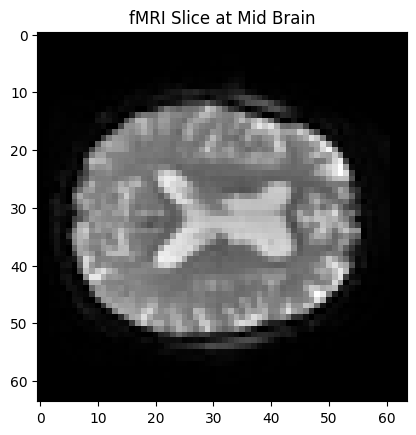

In [8]:
# Example fMRI file path
fmri_file = dataset_path_fmri_parkinson + 'sub-0202/ses-01/func/sub-0202_ses-01_task-rest_bold.nii.gz'

#Load the fMRI data of that file using NiBabel
fmri_img = nib.load(fmri_file)

# Get the fMRI data as numPy array
fmri_data = fmri_img.get_fdata()

#print the shape of the fMRI data (width x height x depth x timepoints)
print(f"fMRI Data Shape:{fmri_data.shape}")

# Visualize a slice of the fMRI data
plt.imshow(fmri_data[:,:,fmri_data.shape[2] // 2, 0], cmap = 'gray')
plt.title('fMRI Slice at Mid Brain')
plt.show()

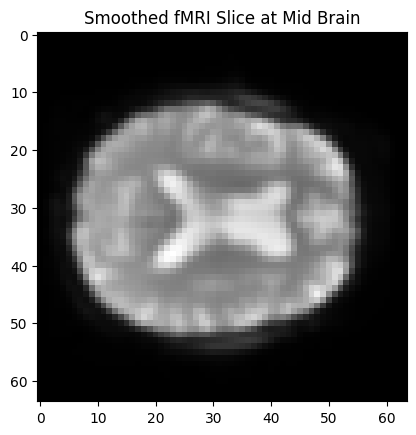

In [9]:
# Apply spatial smoothing (e.g., 6mm smoothing kernel)
smoothed_fmri_img = smooth_img(fmri_img, fwhm=6)

# Extract the smoothed data
smoothed_fmri_data = smoothed_fmri_img.get_fdata()

# Visualize a slice of the smoothed fMRI data
plt.imshow(smoothed_fmri_data[:, :, smoothed_fmri_data.shape[2] // 2, 0], cmap='gray')
plt.title('Smoothed fMRI Slice at Mid Brain')
plt.show()


In [10]:
"""# Path to the main fMRI dataset folder
dataset_path_fmri_parkinson = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/'

# Define a new folder for the cleaned data
cleaned_data_folder = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_cleaned/'

# Create the cleaned data folder if it doesn't exist
os.makedirs(cleaned_data_folder, exist_ok=True)

# Loop through each subject folder
for subject in os.listdir(dataset_path_fmri_parkinson):
    # Check if the folder name starts with 'sub-'
    if subject.startswith('sub-'):
        # Path to the func folder for the subject
        func_folder_path = os.path.join(dataset_path_fmri_parkinson, subject, 'ses-01', 'func')

        # Find the .nii.gz file inside the func folder
        for file in os.listdir(func_folder_path):
            if file.endswith('.nii.gz'):
                # Full path to the original fMRI file
                fmri_file_path = os.path.join(func_folder_path, file)

                # Load the fMRI image
                fmri_img = nib.load(fmri_file_path)

                # Apply motion correction and filtering
                cleaned_fmri_img = clean_img(
                    fmri_img,
                    detrend=True,
                    standardize=True,
                    low_pass=0.1,
                    high_pass=0.01,
                    t_r=2.0
                )

                # Define the output path in the cleaned data folder
                cleaned_output_path = os.path.join(cleaned_data_folder, f'{subject}_cleaned.nii.gz')

                # Save the cleaned data in the cleaned folder
                cleaned_fmri_img.to_filename(cleaned_output_path)

                print(f"Processed and saved cleaned fMRI data for subject: {subject} in {cleaned_data_folder}")
"""

'# Path to the main fMRI dataset folder\ndataset_path_fmri_parkinson = \'/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/\'\n\n# Define a new folder for the cleaned data\ncleaned_data_folder = \'/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_cleaned/\'\n\n# Create the cleaned data folder if it doesn\'t exist\nos.makedirs(cleaned_data_folder, exist_ok=True)\n\n# Loop through each subject folder\nfor subject in os.listdir(dataset_path_fmri_parkinson):\n    # Check if the folder name starts with \'sub-\'\n    if subject.startswith(\'sub-\'):\n        # Path to the func folder for the subject\n        func_folder_path = os.path.join(dataset_path_fmri_parkinson, subject, \'ses-01\', \'func\')\n\n        # Find the .nii.gz file inside the func folder\n        for file in os.listdir(func_folder_path):\n            if file.endswith(\'.nii.gz\'):\n                # Full path to the original fMRI file\n                fmri_file_path = os.path.join(func_folder_path, file)\n\n  

Why Extract Time-Series Data?

The goal of functional connectivity analysis is to understand how different regions of the brain communicate over time.

To do this, we need to define Regions of Interest (ROIs) in the brain and then extract the average signal (time-series) for each ROI across the entire scan.
This time-series data will allow us to calculate correlations between regions, which is the basis for functional connectivity.

How to Extract Time-Series Data?

To extract time-series data from specific regions, we’ll use a brain atlas. A brain atlas divides the brain into anatomical or functional regions, each representing a distinct area of interest.

Choose a Brain Atlas:

Common atlases include the AAL (Automated Anatomical Labeling), Harvard-Oxford, or Schaefer atlas. These atlases can be downloaded and are compatible with packages like Nilearn.
Load the Atlas and Extract Regions:

Load the atlas, which defines different ROIs in the brain.
Use the atlas to extract the average time-series for each region in the cleaned fMRI data.

In [11]:
from nilearn import datasets, image, masking
from nilearn.input_data import NiftiLabelsMasker
import pickle
import os

In [12]:
#path to save/load the time series data
time_series_data_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/time_series_data.pkl'


#check if the time-series data file already exists
if os.path.exists(time_series_data_file):
  #load the time-series data from the file
  with open(time_series_data_file, 'rb') as file:
    time_series_data = pickle.load(file)
  print("Loaded time-series data from file.")
else:
  #Run this block only if the file does not exist

  #load an atlas
  atlas = datasets.fetch_atlas_aal()
  atlas_filename = atlas.maps

  #initilize the masker with the atlas
  masker = NiftiLabelsMasker(labels_img=atlas_filename,standardize=True, t_r=2.0)

  #Path to the cleaned data folder
  cleaned_data_folder = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_cleaned/'

  time_series_data = {}

  #loop through each cleaned fMRI file and extract time-series data
  for file in os.listdir(cleaned_data_folder):
    if file.endswith('_cleaned.nii.gz'):
      subject_id = file.split('_')[0] #extract subject ID from file name
      cleaned_fmri_path = os.path.join(cleaned_data_folder,file)

      #Extract time-series for each region using atlas
      time_series = masker.fit_transform(cleaned_fmri_path)

      #store the time series data
      time_series_data[subject_id] = time_series

      print(f"Extracted Time-series data for subject: {subject_id}")

    #save the extracted data to the file
    with open(time_series_data_file,'wb') as file:
      pickle.dump(time_series_data,file)
    print("Saved time-series data to file")

#Example: Access time-series for a specific subject
example_subject_id = list(time_series_data.keys())[0]
print(f"time-series shape for {example_subject_id}: {time_series_data[example_subject_id].shape}")

Loaded time-series data from file.
time-series shape for sub-2140: (300, 116)


**Analyze functional connectivity**

**Step-1: Calculate the Functional Connectivity Matrix**

The goal of functional connectivity analysis is to understand how brain regions are related. We do this by calculating the correlation between the time-series data of each pair of regions. This results in a connectivity matrix where each cell shows how strongly two regions are connected.

What is a Functional Connectivity Matrix?

It’s a matrix where:
Rows and columns represent different brain regions.
Each cell in the matrix shows the correlation between the time-series of two regions.
This matrix tells us which regions are "communicating" or showing synchronized activity.

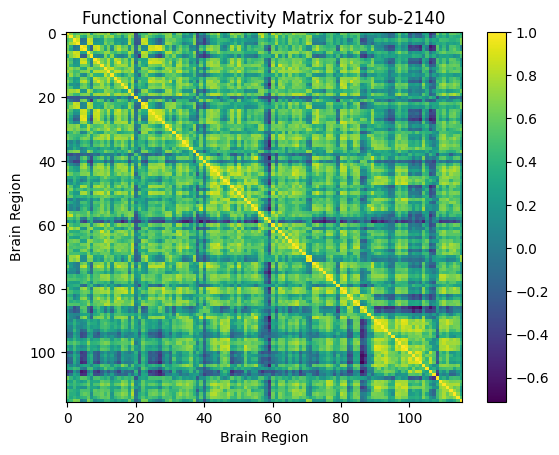

In [13]:
#Dictionary to store functional connectivity matrices for each subject
functional_connectivity_matrices = {}

for subject_id, time_series in time_series_data.items():
  #calc the pearson correlation matrix for time_series_data
  connectivity_matrix = np.corrcoef(time_series,rowvar=False)

  #store the connectivity matrix
  functional_connectivity_matrices[subject_id] = connectivity_matrix

 # print(f"Computed functional connectivity matrix for subject: {subject_id}")

  #Optional: Visualize the connectivity matrix for one subject
  if subject_id == "sub-2140": #we can change to any subject we like
    plt.imshow(connectivity_matrix, cmap='viridis',aspect="auto")
    plt.colorbar()
    plt.title(f"Functional Connectivity Matrix for {subject_id}")
    plt.xlabel("Brain Region")
    plt.ylabel("Brain Region")
    plt.show()

**What This Data Represents**
This data combines two main types of information:

Functional Connectivity Data:

This part of the data shows how different regions in the brain “talk” to each other. Each subject's brain activity was measured using fMRI (functional Magnetic Resonance Imaging) while they were at rest.
We took these fMRI measurements and calculated a connectivity matrix for each subject. This matrix shows how brain regions are correlated (how similar their activity patterns are).

The connectivity matrix was then "flattened" into a single long list of numbers (a sequence) for each subject, which allows us to use it as input for machine learning models.

Cognitive Scores:

This part contains scores that measure different aspects of each subject’s cognitive (thinking) abilities.
There are several cognitive categories, including attention, executive function (decision-making skills), memory, language, visuospatial ability (understanding visual information), and global cognition (overall cognitive ability).
These scores help us understand each subject's mental abilities. Some scores may be high (better ability), while others may be lower (indicating cognitive challenges).

**Why We Combine These Two Types of Data**

By combining brain connectivity data with cognitive scores, we’re trying to find patterns between how the brain’s connectivity might relate to different cognitive abilities or impairments.

**For example:**

If certain brain regions don’t communicate well together (low connectivity), it might be linked to lower scores in memory or attention.
If there are specific patterns in connectivity associated with high scores in attention or executive function, we may be able to predict these scores just from brain connectivity.

In [14]:
# Path to the cognitive domains file
cognitive_scores_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/phenotype/cognitive_domains.tsv'

# Load cognitive scores into a DataFrame
cognitive_scores_df = pd.read_csv(cognitive_scores_file, sep='\t')

In [15]:
# Flatten connectivity matrices and align with cognitive scores
functional_connectivity_matrices = {subject_id: np.corrcoef(time_series, rowvar=False) for subject_id, time_series in time_series_data.items()}
flattened_sequences = {k: v.flatten() for k, v in functional_connectivity_matrices.items()}

In [16]:
# Remove 'sub-' prefix from both functional connectivity and cognitive scores data
adjusted_flattened_sequences = {subject_id.replace('sub-', '').zfill(4): sequence for subject_id, sequence in flattened_sequences.items()}
cognitive_scores_df['participant_id'] = cognitive_scores_df['participant_id'].str.replace('sub-', '').str.zfill(4)

In [17]:
cognitive_scores_df

,participant_id,attention,executive,global,language,memory,visuospatial
0,0202,0.74333,0.08219,-0.12135,0.58319,-1.26360,-0.181613
1,0203,0.22898,-0.72817,0.25027,-0.24200,-0.66063,-0.377471
2,0204,0.18272,0.18931,0.41475,-0.36043,0.95818,-0.769186
3,0205,0.35645,0.12266,0.29293,-0.25917,0.61895,-2.923620
4,0206,0.30705,0.00481,-0.15784,-1.18563,0.46936,0.601817
5,0207,0.62534,0.96298,1.02999,0.33756,0.43116,1.385247
6,0209,0.45892,0.41552,0.32941,0.61332,0.58259,0.210102
7,0210,0.61256,0.93263,0.62807,0.30847,0.61987,1.189390
8,0212,-0.46109,-0.21207,-0.11517,0.91712,-0.36007,0.405959
9,0213,0.37088,0.45054,0.74989,-0.37550,-0.02038,0.601817


In [18]:
# Path to the cognitive domains file
cognitive_scores_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/fmri_Parkinson/phenotype/cognitive_domains.tsv'

# Load cognitive scores into a DataFrame
cognitive_scores_df = pd.read_csv(cognitive_scores_file, sep='\t')

# Flatten connectivity matrices and align with cognitive scores
functional_connectivity_matrices = {subject_id: np.corrcoef(time_series, rowvar=False) for subject_id, time_series in time_series_data.items()}
flattened_sequences = {k: v.flatten() for k, v in functional_connectivity_matrices.items()}

# Remove 'sub-' prefix from both functional connectivity and cognitive scores data
adjusted_flattened_sequences = {subject_id.replace('sub-', '').zfill(4): sequence for subject_id, sequence in flattened_sequences.items()}
cognitive_scores_df['participant_id'] = cognitive_scores_df['participant_id'].str.replace('sub-', '').str.zfill(4)

# Align the scores with the functional connectivity data
aligned_data = []
for subject_id, flattened_sequence in adjusted_flattened_sequences.items():
    if subject_id in cognitive_scores_df['participant_id'].values:
        scores = cognitive_scores_df[cognitive_scores_df['participant_id'] == subject_id].iloc[0]
        record = {
            'subject_id': subject_id,
            'connectivity': flattened_sequence,
            'attention': scores['attention'],
            'executive': scores['executive'],
            'global': scores['global'],
            'language': scores['language'],
            'memory': scores['memory'],
            'visuospatial': scores['visuospatial']
        }
        aligned_data.append(record)

# Convert to DataFrame and save without PCA
aligned_df = pd.DataFrame(aligned_data)
aligned_data_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/aligned_connectivity_scores_clean.pkl'
aligned_df.to_pickle(aligned_data_file)
print("Initial aligned_df saved without PCA.")

Initial aligned_df saved without PCA.


In [19]:
# Fill missing values with the median without triggering the warning
aligned_df = aligned_df.assign(visuospatial=aligned_df['visuospatial'].fillna(aligned_df['visuospatial'].median()))
from sklearn.preprocessing import StandardScaler

# Scale cognitive scores
scaler = StandardScaler()
aligned_df[['attention', 'executive', 'global', 'language', 'memory', 'visuospatial']] = scaler.fit_transform(
    aligned_df[['attention', 'executive', 'global', 'language', 'memory', 'visuospatial']]
)


aligned_df

,subject_id,connectivity,attention,executive,global,language,memory,visuospatial
0,2140,"[0.9999999999999998, 0.7049516665506806, 0.492...",-6.181012,-5.489001,-1.959711,-0.436806,-1.456648,0.206242
1,0227,"[1.0, 0.7264209794122581, 0.8180159291506557, ...",0.448881,0.252320,-1.159329,-0.586978,1.254090,0.611735
2,0272,"[1.0, 0.860733695745355, 0.6675504917150709, 0...",-0.087558,0.105739,-0.063615,0.607856,-0.491511,0.611735
3,0243,"[1.0, 0.734537712346681, 0.7213373609503154, 0...",-0.480793,-0.335938,-0.145445,1.434788,-0.676638,0.003496
4,2141,"[0.9999999999999998, 0.8848666398099524, 0.876...",-1.775870,-3.089356,-4.202294,-4.286972,-3.053882,0.206242
5,0226,"[0.9999999999999998, 0.6335642915247438, 0.811...",0.560932,0.674684,0.755293,0.692907,0.695968,0.408988
6,2122,"[0.9999999999999998, 0.5453707672223519, 0.765...",-0.021655,0.158686,1.177211,0.388906,1.031295,0.408988
7,0210,"[1.0, 0.984128181100264, 0.9846278632289283, 0...",0.592837,0.890822,0.585244,0.288791,0.585704,1.219974
8,2125,"[0.9999999999999998, 0.7052784555368062, 0.818...",0.193788,0.139176,0.119222,1.063238,0.548499,-0.401997
9,0242,"[1.0, 0.8348938082512464, 0.7952166596214039, ...",0.664001,0.616973,0.874838,0.676624,-0.305467,-0.199251


**Step 1: Identifying Outliers Using Z-Scores**

In [20]:
from scipy.stats import zscore
import numpy as np

# Calculate Z-scores for each cognitive score column
z_scores = aligned_df[['attention', 'executive', 'global', 'language', 'memory', 'visuospatial']].apply(zscore)

# Define a threshold for identifying outliers
threshold = 3

# Identify outliers: any value with an absolute Z-score > threshold
outliers = (np.abs(z_scores) > threshold)

# Print the number of outliers in each cognitive score column
print("Number of outliers in each column:")
print(outliers.sum())


Number of outliers in each column:
attention       1
executive       2
global          1
language        1
memory          2
visuospatial    1
dtype: int64


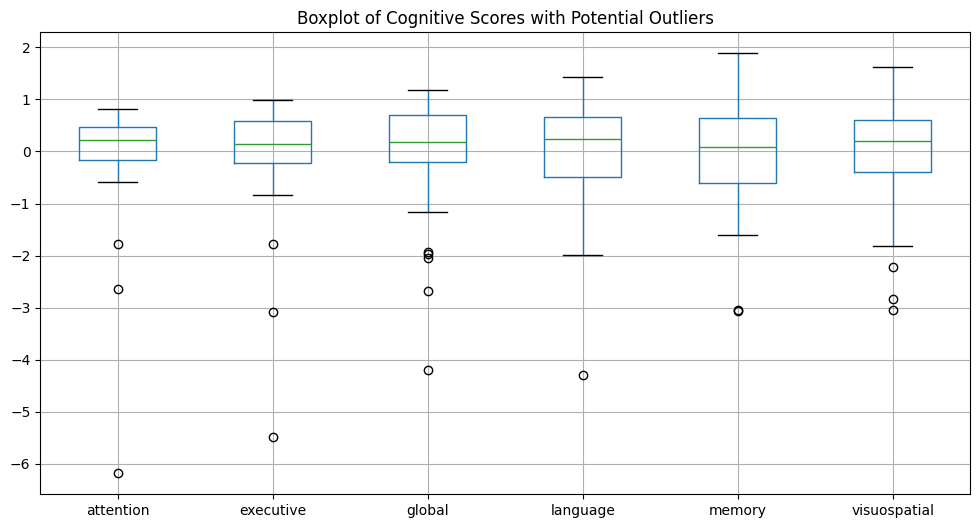

In [21]:
import matplotlib.pyplot as plt

# Plot box plots for each cognitive score to visualize outliers
plt.figure(figsize=(12, 6))
aligned_df[['attention', 'executive', 'global', 'language', 'memory', 'visuospatial']].boxplot()
plt.title("Boxplot of Cognitive Scores with Potential Outliers")
plt.show()


**Cognitive Score Data and Outliers** The dataset consists of cognitive scores across various domains, including attention, executive function, global cognition, language, memory, and visuospatial ability. Each domain reflects a different aspect of cognitive functioning, potentially contributing to our goal of predicting Parkinson's disease. The data underwent preprocessing steps, including standardization, imputation of missing values, and analysis of outliers.

**Distribution and Outliers**

A boxplot analysis highlighted the distribution of scores for each domain. Here are the notable observations:

Attention: Contains 1 outlier on the lower end.

Executive: Contains 2 outliers on the lower end.

Global Cognition: Contains 1 outlier on the lower end.

Language: Contains 1 outlier on the lower end.

Memory: Contains 2 outliers on the lower end.

Visuospatial Ability: Contains 1 outlier on the lower end.

**Considerations for Outliers**
Outliers in cognitive data may represent meaningful individual differences or be indicative of data anomalies. The following options are considered:

Retaining Outliers: Keeping outliers could preserve unique variations in cognitive profiles, potentially valuable for predictive modeling.

**Removing Outliers**: Excluding extreme values might improve model performance if these data points distort the results.

**Transforming Data**: Applying transformations (e.g., log, robust scaling) could reduce the impact of outliers without full removal.
Given the importance of individual differences in cognitive assessments, we are inclined to retain the outliers initially and monitor their effect on model performance. Adjustments will be made if outliers are found to negatively impact predictive accuracy during model training.

In [22]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Step 1: Prepare connectivity features
# Convert the list of connectivity matrices in `aligned_df` to a numpy array
connectivity_features = np.array(aligned_df['connectivity'].tolist())

# Step 2: Apply PCA to reduce dimensions
# Set PCA to retain 90% of variance
pca = PCA(n_components=0.90)
reduced_connectivity = pca.fit_transform(connectivity_features)

# Check how many components were retained
print(f"Number of PCA components retained: {reduced_connectivity.shape[1]}")

# Step 3: Combine PCA components with cognitive scores
# Convert the PCA result to a DataFrame
pca_df = pd.DataFrame(reduced_connectivity, columns=[f'PCA_{i+1}' for i in range(reduced_connectivity.shape[1])])

# Add cognitive scores to this DataFrame
cognitive_scores = aligned_df[['attention', 'executive', 'global', 'language', 'memory', 'visuospatial']].reset_index(drop=True)
combined_df = pd.concat([pca_df, cognitive_scores], axis=1)

# Display the combined data to verify
print("Combined data with PCA components and cognitive scores:")
print(combined_df.head())

# Optional: Save the combined data for future use
combined_data_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/combined_pca_cognitive_scores.pkl'
combined_df.to_pickle(combined_data_file)
print(f"Combined data saved to {combined_data_file}")


Number of PCA components retained: 19
Combined data with PCA components and cognitive scores:
       PCA_1     PCA_2     PCA_3     PCA_4      PCA_5     PCA_6     PCA_7  \
0  -5.152932 -8.203098  8.325937 -5.599462 -10.524621 -9.708197  5.989126   
1 -11.151929  3.739712  0.656019 -2.283593   3.537284 -2.165577 -7.293300   
2 -10.031441 -8.803892  4.943030  1.929827  -0.139040  6.151501  1.012230   
3 -17.592226 -5.784041  2.714891  1.161402   2.426786 -0.439606  5.354479   
4 -10.370400 -6.782035  0.161765 -8.321737 -11.850944 -4.489055 -1.304732   

      PCA_8     PCA_9    PCA_10  ...    PCA_16    PCA_17    PCA_18    PCA_19  \
0 -3.168180  6.840991 -0.706619  ... -0.739794 -6.413458  1.184803  5.098404   
1 -5.454617  3.230714  1.435630  ...  2.331262 -3.056839  3.479174  0.340592   
2  1.492547  0.381540 -5.223200  ... -6.117607  3.395925 -0.241193 -1.334233   
3  4.545732  2.231147 -5.918487  ... -2.156145  2.341406  0.243632  1.344578   
4 -1.014515 -8.516413 -5.187754  ...  7.551

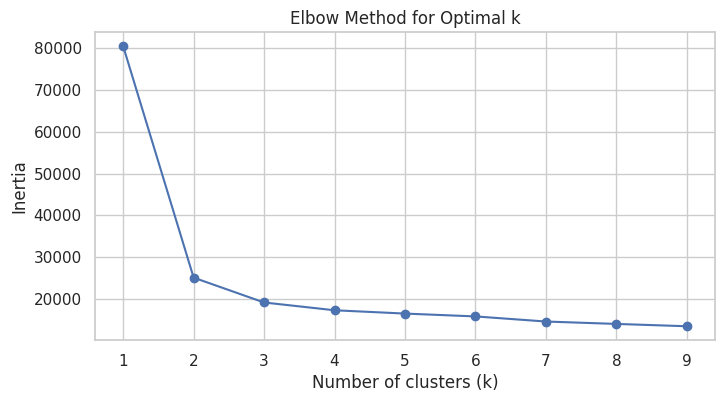

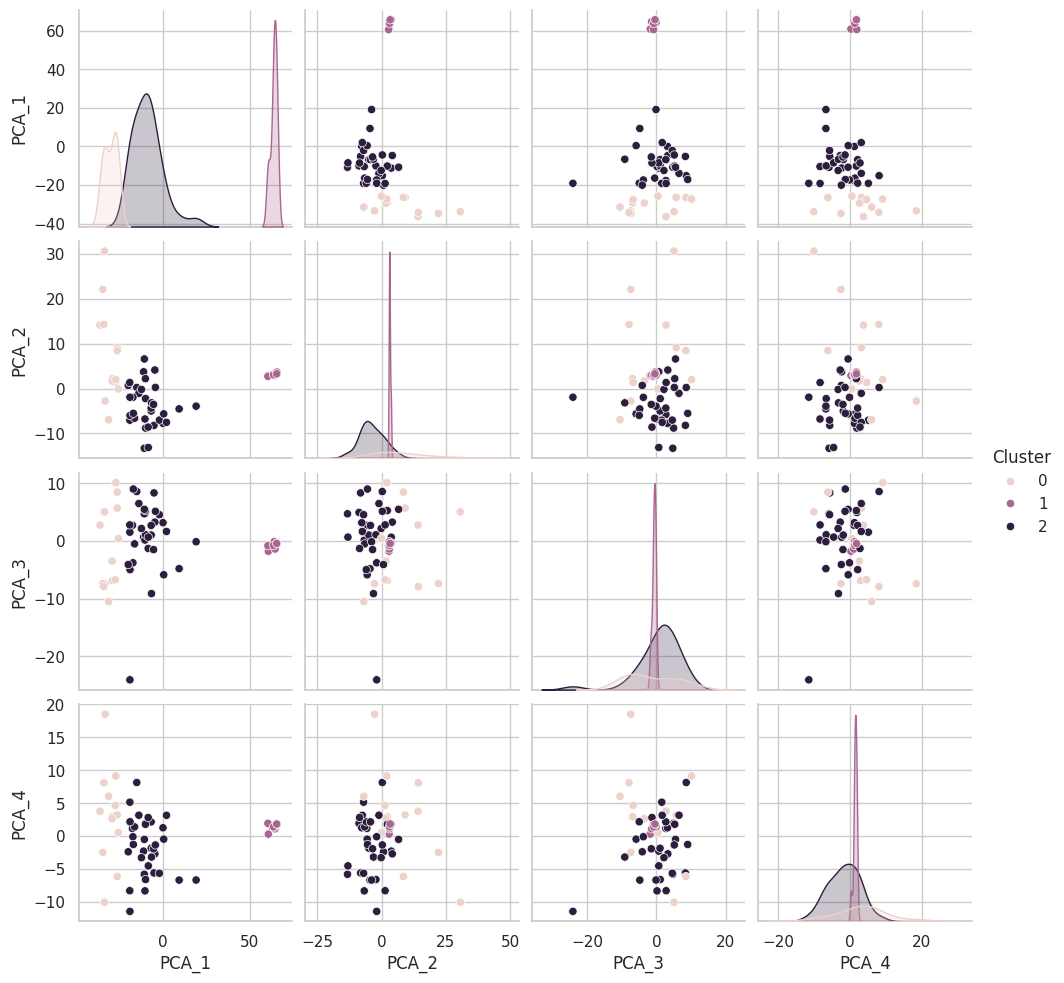

Clustered data saved to /content/drive/MyDrive/AI-BNDP_Prediction/data/clustered_data.pkl


In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select PCA components for clustering
# Assume columns `PCA_1, PCA_2, ...` are the PCA-reduced features
pca_features = combined_df.filter(regex='PCA_')

# Step 2: Determine optimal number of clusters (Optional: using the Elbow Method)
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Step 3: Apply K-Means Clustering
# Choose an optimal k based on the elbow plot (e.g., k=3 or k=4)
kmeans = KMeans(n_clusters=3, random_state=42)
combined_df['Cluster'] = kmeans.fit_predict(pca_features)

# Step 4: Visualize Clustering Results
sns.pairplot(combined_df, vars=pca_features.columns[:4], hue='Cluster')
plt.show()

# Optional: Save the clustered data
clustered_data_file = '/content/drive/MyDrive/AI-BNDP_Prediction/data/clustered_data.pkl'
combined_df.to_pickle(clustered_data_file)
print(f"Clustered data saved to {clustered_data_file}")


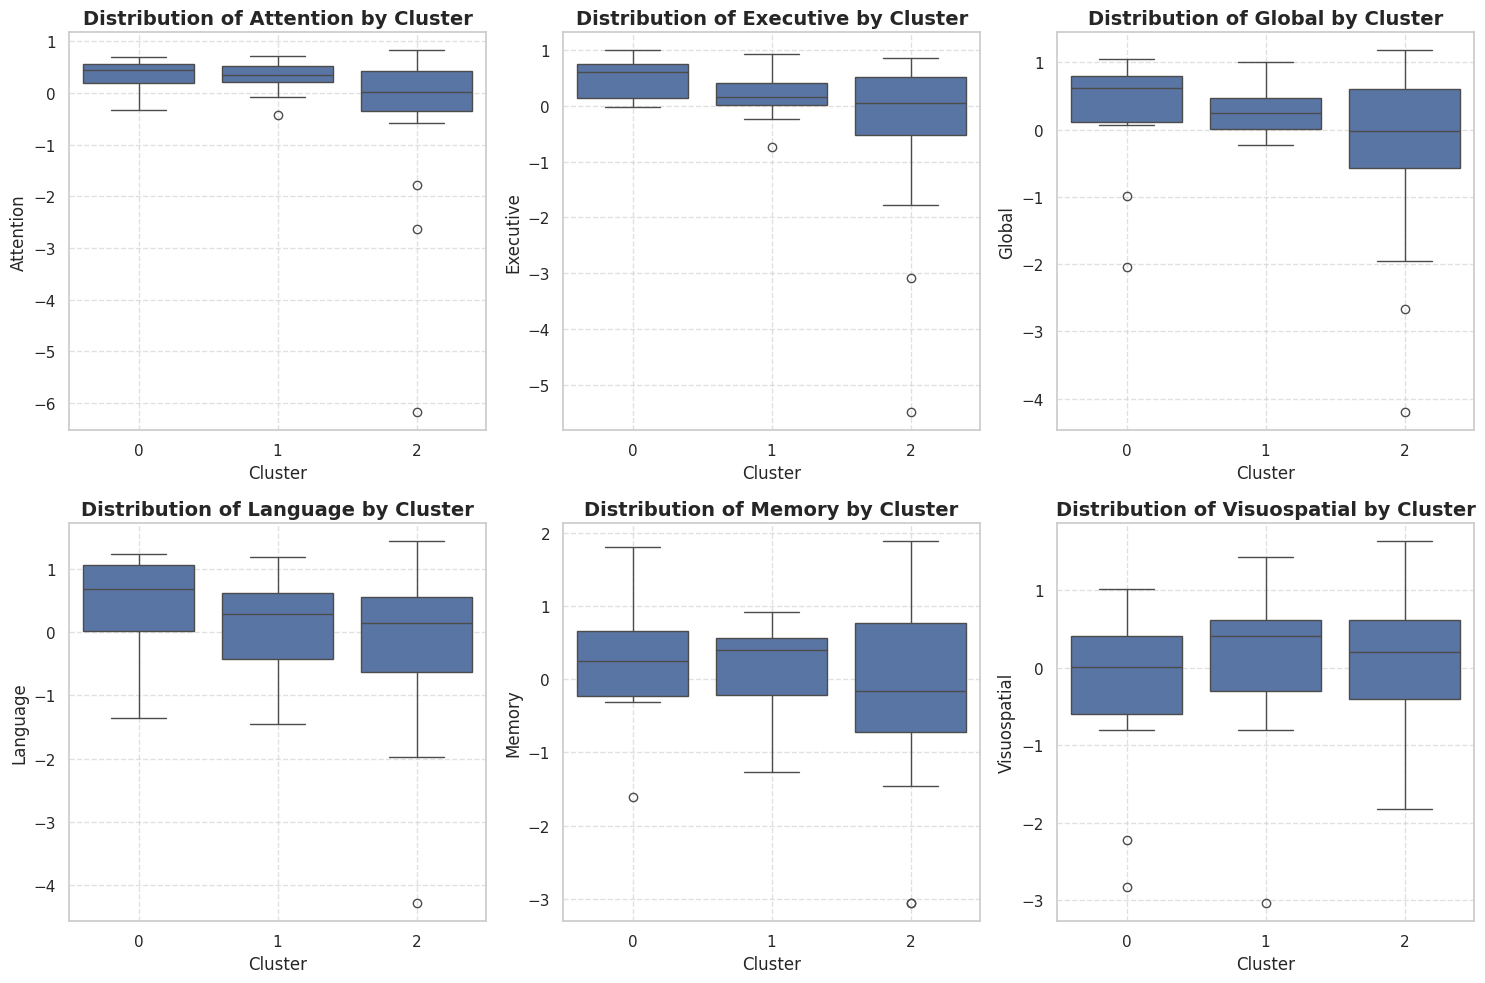

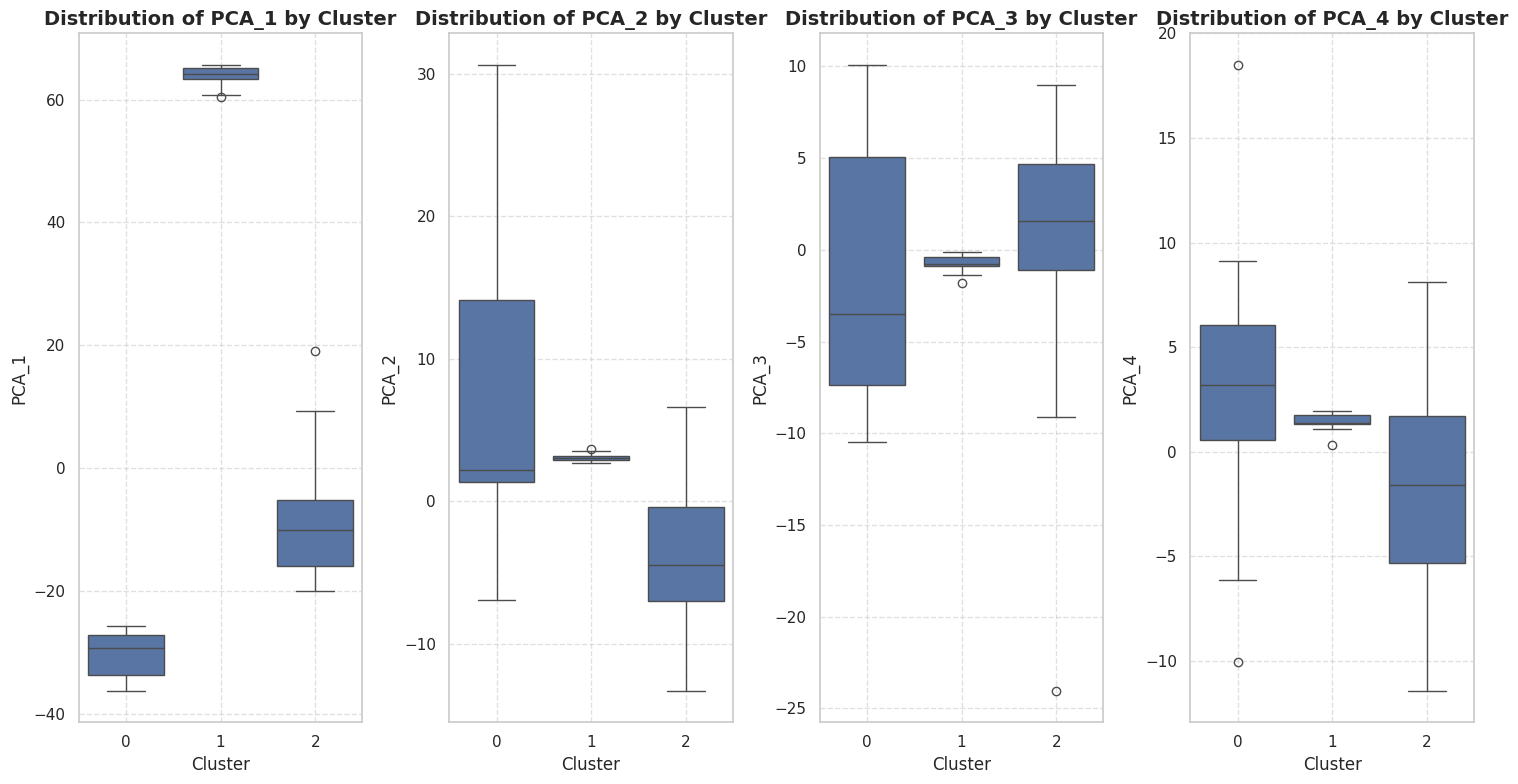

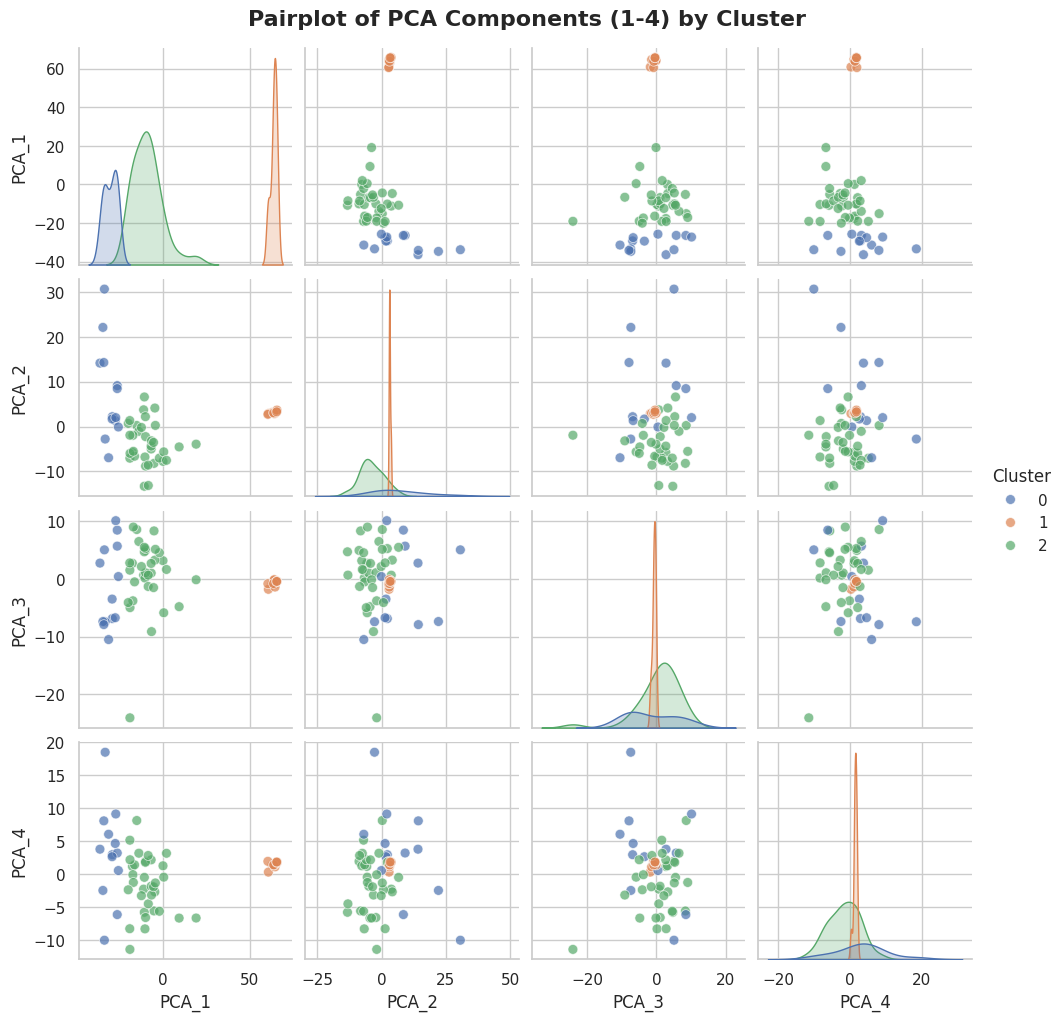

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure our plots are styled professionally
sns.set(style="whitegrid")

# Plotting cognitive scores by cluster with titles, labels, and professional styling
cognitive_scores = ["attention", "executive", "global", "language", "memory", "visuospatial"]
plt.figure(figsize=(15, 10))
for i, score in enumerate(cognitive_scores, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=combined_df, x='Cluster', y=score)
    plt.title(f"Distribution of {score.capitalize()} by Cluster", fontsize=14, weight='bold')
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel(score.capitalize(), fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Plotting PCA components by cluster for the first few components to observe distribution differences
pca_components = [f"PCA_{i+1}" for i in range(4)]
plt.figure(figsize=(15, 8))
for i, pca in enumerate(pca_components, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=combined_df, x='Cluster', y=pca)
    plt.title(f"Distribution of {pca} by Cluster", fontsize=14, weight='bold')
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel(pca, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Pairplot for PCA components 1 through 4 with clusters, focusing on distribution and separation
sns.pairplot(data=combined_df, vars=pca_components, hue='Cluster', palette='deep', diag_kind='kde', plot_kws={'s': 50, 'alpha':0.7})
plt.suptitle("Pairplot of PCA Components (1-4) by Cluster", y=1.02, fontsize=16, weight='bold')
plt.show()


**Analysis for Plots Above**








In [24]:
!pip install ace_tools

In [32]:
# Calculate summary statistics for each cluster
cluster_stats = combined_df.groupby('Cluster').agg(['mean', 'median', 'std'])

# Display summary statistics
from IPython.display import display
display(cluster_stats)
print("Summary statistics for each cluster:")
print(cluster_stats)

PCA_1                          PCA_2                       \
              mean     median       std      mean    median        std   
Cluster                                                                  
0       -30.377732 -29.294416  3.688004  7.400056  2.207459  10.587985   
1        63.804656  64.131873  1.792681  3.103187  3.051942   0.281955   
2        -9.027668 -10.075040  8.575834 -3.833406 -4.443749   4.616751   

            PCA_3                         PCA_4  ...  language    memory  \
             mean    median       std      mean  ...       std      mean   
Cluster                                          ...                       
0       -1.366474 -3.482256  7.077373  3.142816  ...  0.821349  0.251289   
1       -0.742490 -0.782186  0.501003  1.425688  ...  0.783263  0.112935   
2        0.762693  1.587160  6.110680 -1.662917  ...  1.106960 -0.132619   

                            visuospatial                     cluster         \
           median       std         mean    median       std    mean median   
Cluster                                                                       
0        0.251285  0.844236    -0.292826  0.003496  1.139762     0.0    0.0   
1        0.399670  0.654356     0.058790  0.408988  1.220159     1.0    1.0   
2       -0.156864  1.149521     0.092943  0.206242  0.888939     2.0    2.0   

              
         std  
Cluster       
0        0.0  
1        0.0  
2        0.0  

[3 rows x 78 columns]

Summary statistics for each cluster:
             PCA_1                          PCA_2                       \
              mean     median       std      mean    median        std   
Cluster                                                                  
0       -30.377732 -29.294416  3.688004  7.400056  2.207459  10.587985   
1        63.804656  64.131873  1.792681  3.103187  3.051942   0.281955   
2        -9.027668 -10.075040  8.575834 -3.833406 -4.443749   4.616751   

            PCA_3                         PCA_4  ...  language    memory  \
             mean    median       std      mean  ...       std      mean   
Cluster                                          ...                       
0       -1.366474 -3.482256  7.077373  3.142816  ...  0.821349  0.251289   
1       -0.742490 -0.782186  0.501003  1.425688  ...  0.783263  0.112935   
2        0.762693  1.587160  6.110680 -1.662917  ...  1.106960 -0.132619   

                            visuospatial                     

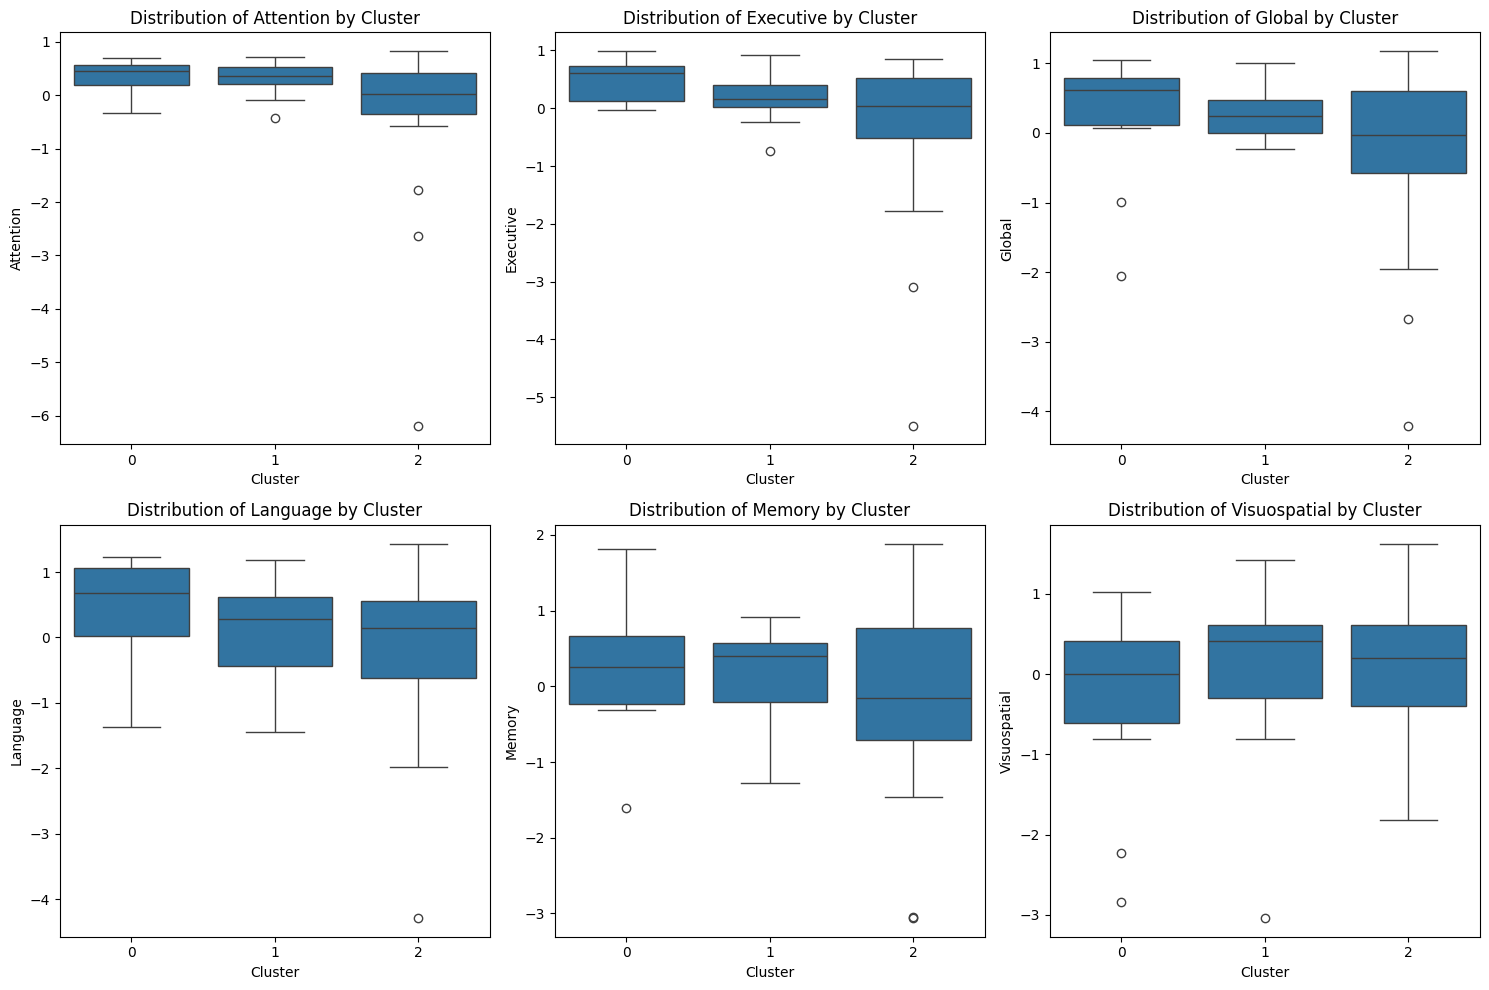

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cognitive score columns
cognitive_scores = ['attention', 'executive', 'global', 'language', 'memory', 'visuospatial']

# Set up the plot grid
plt.figure(figsize=(15, 10))
for i, score in enumerate(cognitive_scores, 1):
    plt.subplot(2, 3, i)  # Arrange plots in 2 rows and 3 columns
    sns.boxplot(data=combined_df, x='Cluster', y=score)
    plt.title(f'Distribution of {score.capitalize()} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(score.capitalize())

plt.tight_layout()
plt.show()


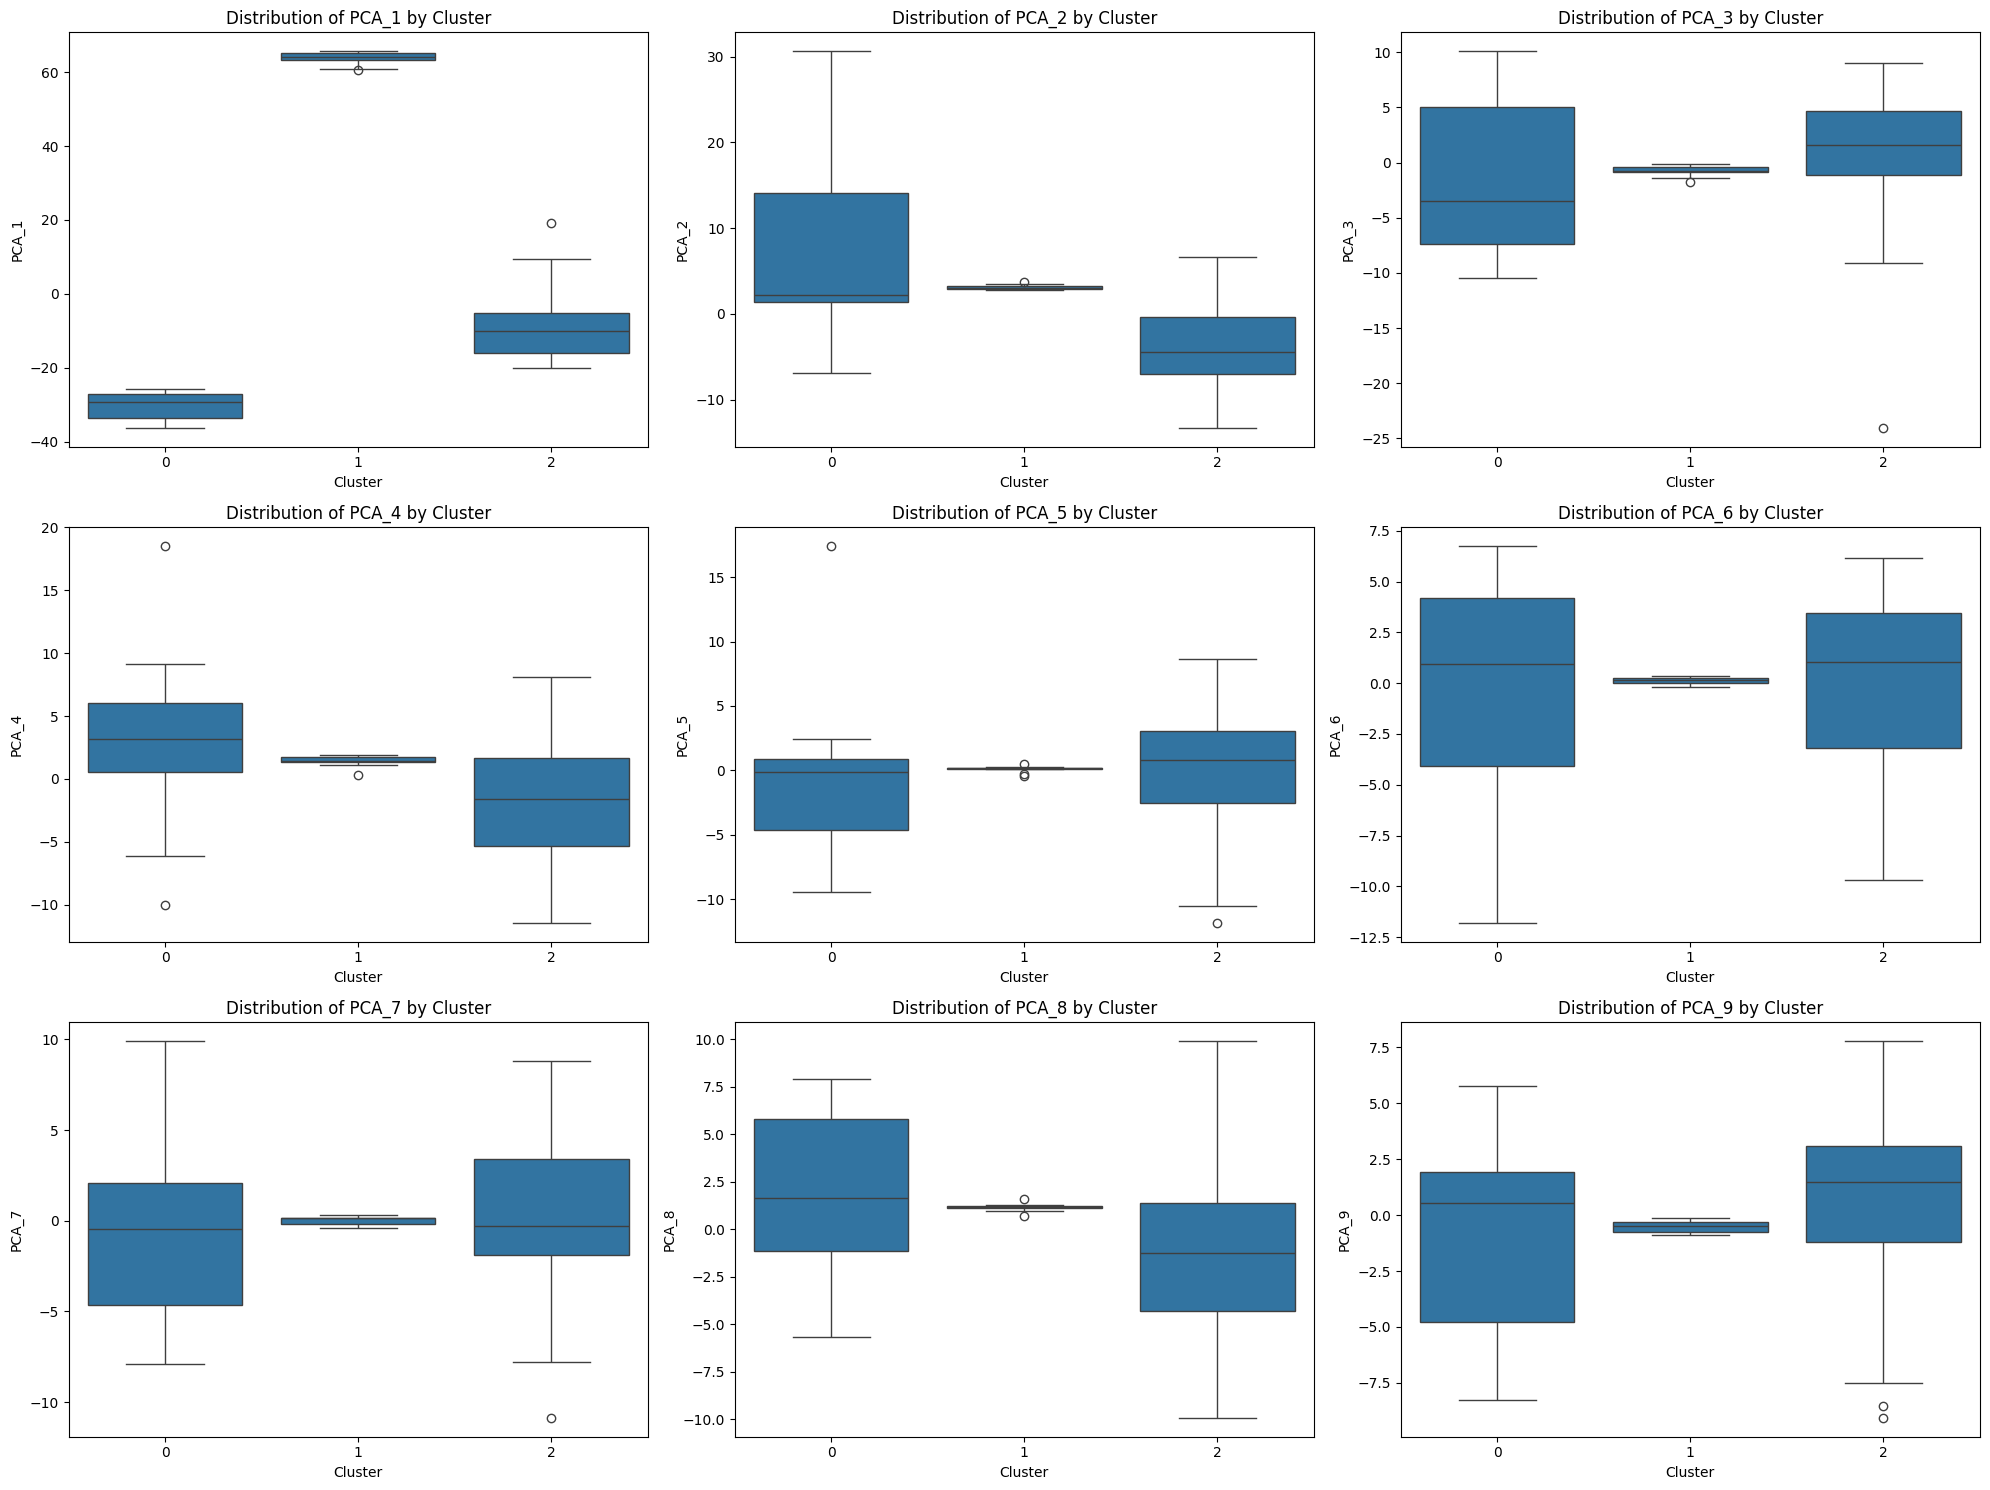

In [27]:
# Select the PCA columns for visualization
pca_columns = [col for col in combined_df.columns if 'PCA' in col]

# Set up the plot grid for PCA components
plt.figure(figsize=(20, 15))
for i, pca_col in enumerate(pca_columns[:9], 1):  # Limit to first 9 PCA components for readability
    plt.subplot(3, 3, i)  # Arrange plots in 3 rows and 3 columns
    sns.boxplot(data=combined_df, x='Cluster', y=pca_col)
    plt.title(f'Distribution of {pca_col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(pca_col)

plt.tight_layout()
plt.show()

In [28]:
# Assuming `aligned_df` contains PCA components and cognitive scores
# Prepare the features for clustering by selecting only the relevant columns (PCA components)

# If the DataFrame contains additional columns like `subject_id`, we exclude them for clustering
clustering_features = aligned_df.drop(columns=['subject_id'], errors='ignore')

# If you previously saved PCA data with cognitive scores to a file, load it back if needed
# combined_data_file = '/path/to/combined_data.pkl'
# clustering_features = pd.read_pickle(combined_data_file)
clustering_features

,connectivity,attention,executive,global,language,memory,visuospatial
0,"[0.9999999999999998, 0.7049516665506806, 0.492...",-6.181012,-5.489001,-1.959711,-0.436806,-1.456648,0.206242
1,"[1.0, 0.7264209794122581, 0.8180159291506557, ...",0.448881,0.252320,-1.159329,-0.586978,1.254090,0.611735
2,"[1.0, 0.860733695745355, 0.6675504917150709, 0...",-0.087558,0.105739,-0.063615,0.607856,-0.491511,0.611735
3,"[1.0, 0.734537712346681, 0.7213373609503154, 0...",-0.480793,-0.335938,-0.145445,1.434788,-0.676638,0.003496
4,"[0.9999999999999998, 0.8848666398099524, 0.876...",-1.775870,-3.089356,-4.202294,-4.286972,-3.053882,0.206242
5,"[0.9999999999999998, 0.6335642915247438, 0.811...",0.560932,0.674684,0.755293,0.692907,0.695968,0.408988
6,"[0.9999999999999998, 0.5453707672223519, 0.765...",-0.021655,0.158686,1.177211,0.388906,1.031295,0.408988
7,"[1.0, 0.984128181100264, 0.9846278632289283, 0...",0.592837,0.890822,0.585244,0.288791,0.585704,1.219974
8,"[0.9999999999999998, 0.7052784555368062, 0.818...",0.193788,0.139176,0.119222,1.063238,0.548499,-0.401997
9,"[1.0, 0.8348938082512464, 0.7952166596214039, ...",0.664001,0.616973,0.874838,0.676624,-0.305467,-0.199251
